# 1. Install / Import Required Libraries

In [1]:
!pip install sdv
!pip install table_evaluator
!pip install pycaret
!pip install pandas
!pip install fairlearn
!pip install shap

In [2]:
import pandas as pd

# SDV for synthetic data
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality

# Visual diagnostics
from table_evaluator import TableEvaluator

# AutoML / classification
from pycaret.classification import setup, compare_models, plot_model

# Fairness metrics
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)

# Modeling utilities
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Constants
SEED = 123
DISCRETE_COLUMNS = [
    'Grade', 'Gender', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC',
    'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR',
    'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA'
]
PROTECTED_ATTRS = ['Gender', 'Race']

## 2. Load & Inspect Real Data


In [3]:
real_data = pd.read_csv('TCGA_InfoWithGrade.csv')
real_data.info()
real_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Grade             839 non-null    int64  
 1   Gender            839 non-null    int64  
 2   Age_at_diagnosis  839 non-null    float64
 3   Race              839 non-null    int64  
 4   IDH1              839 non-null    int64  
 5   TP53              839 non-null    int64  
 6   ATRX              839 non-null    int64  
 7   PTEN              839 non-null    int64  
 8   EGFR              839 non-null    int64  
 9   CIC               839 non-null    int64  
 10  MUC16             839 non-null    int64  
 11  PIK3CA            839 non-null    int64  
 12  NF1               839 non-null    int64  
 13  PIK3R1            839 non-null    int64  
 14  FUBP1             839 non-null    int64  
 15  RB1               839 non-null    int64  
 16  NOTCH1            839 non-null    int64  
 1

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,0,51.30,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,38.72,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,35.17,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,32.78,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,31.51,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Create SDV Metadata & Synthesizer


In [4]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)

synthesizer = TVAESynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=500,
    verbose=False,
    cuda=True
)


## 4. Fit Synthesizer & Generate Synthetic Data


In [5]:
synthesizer.fit(real_data)
synthetic_data = synthesizer.sample(num_rows=real_data.shape[0])
synthetic_data.head()


,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,0,0,35.822080,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,34.954776,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,45.499360,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,33.618514,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,80.086936,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Quantitative & Visual Quality Evaluation


In [6]:
quality_report = evaluate_quality(real_data, synthetic_data, metadata)
print(quality_report)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 24/24 [00:00<00:00, 5911.29it/s]|
Column Shapes Score: 94.85%

(2/2) Evaluating Column Pair Trends: |██████████| 276/276 [00:00<00:00, 749.05it/s]|
Column Pair Trends Score: 90.88%

Overall Score (Average): 92.87%



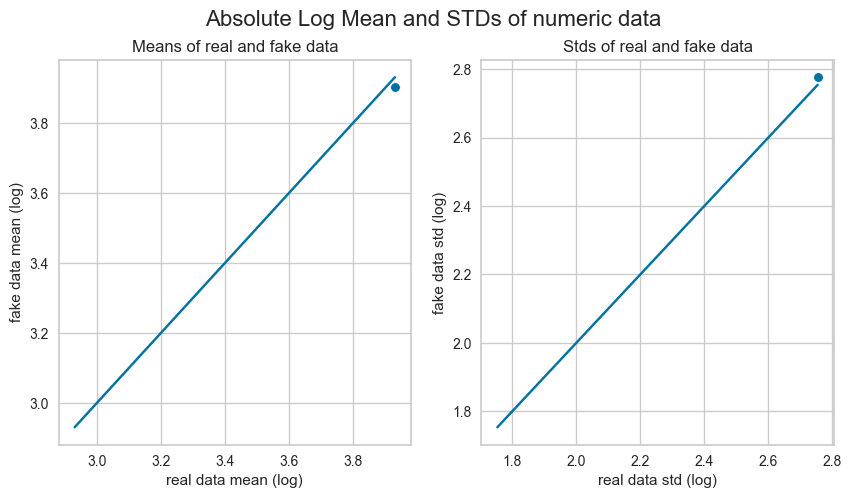

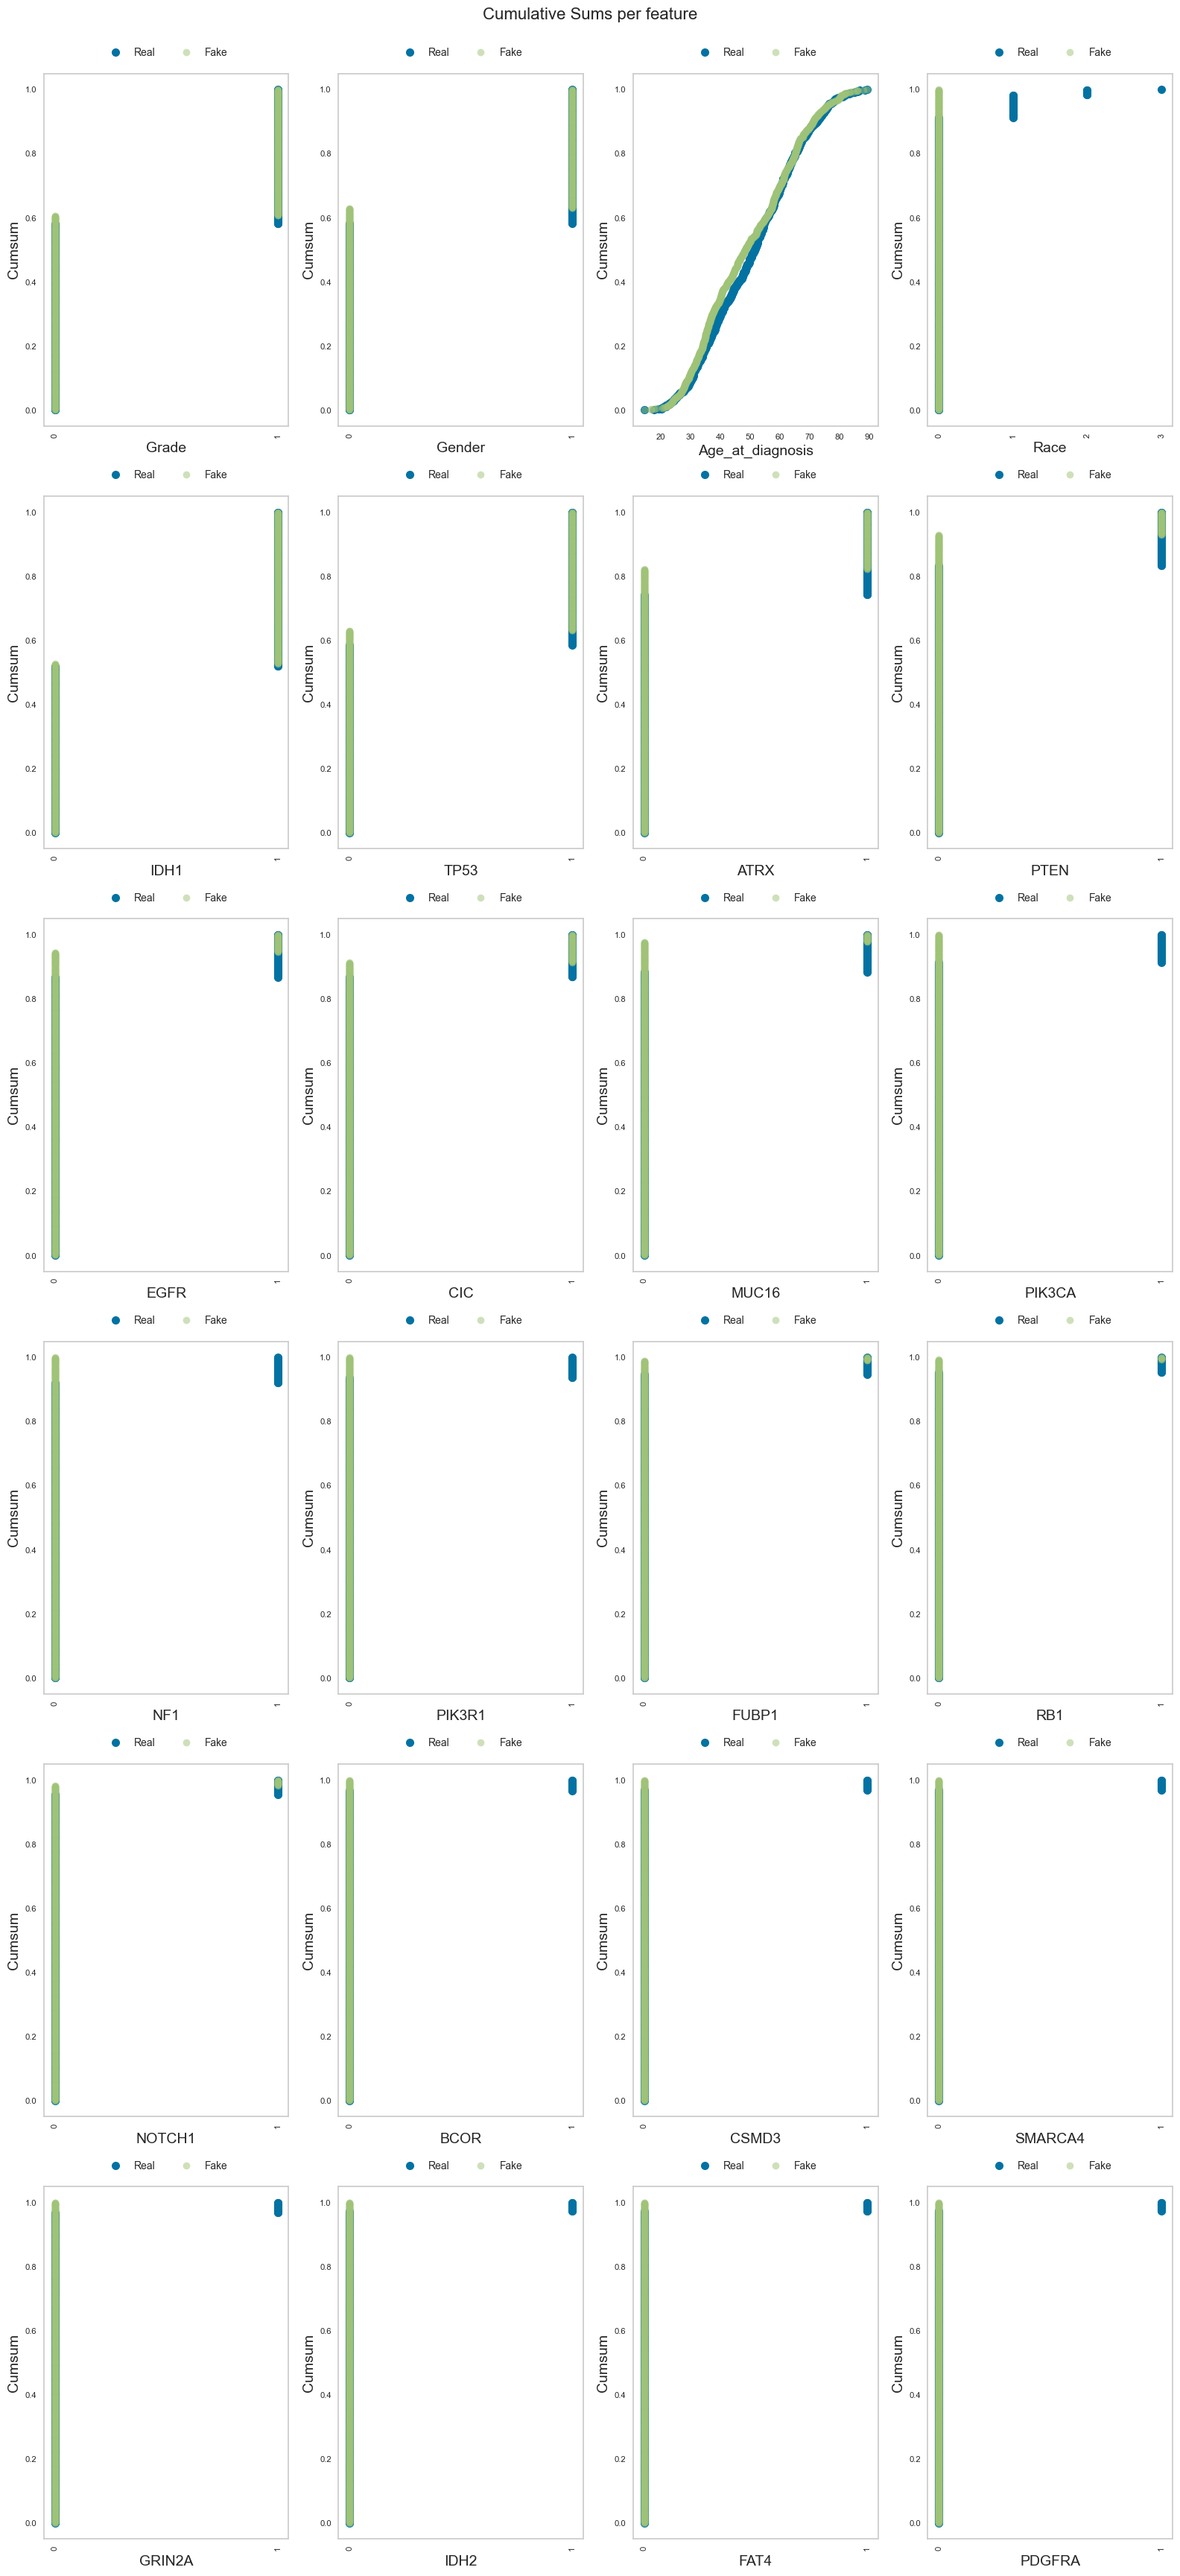

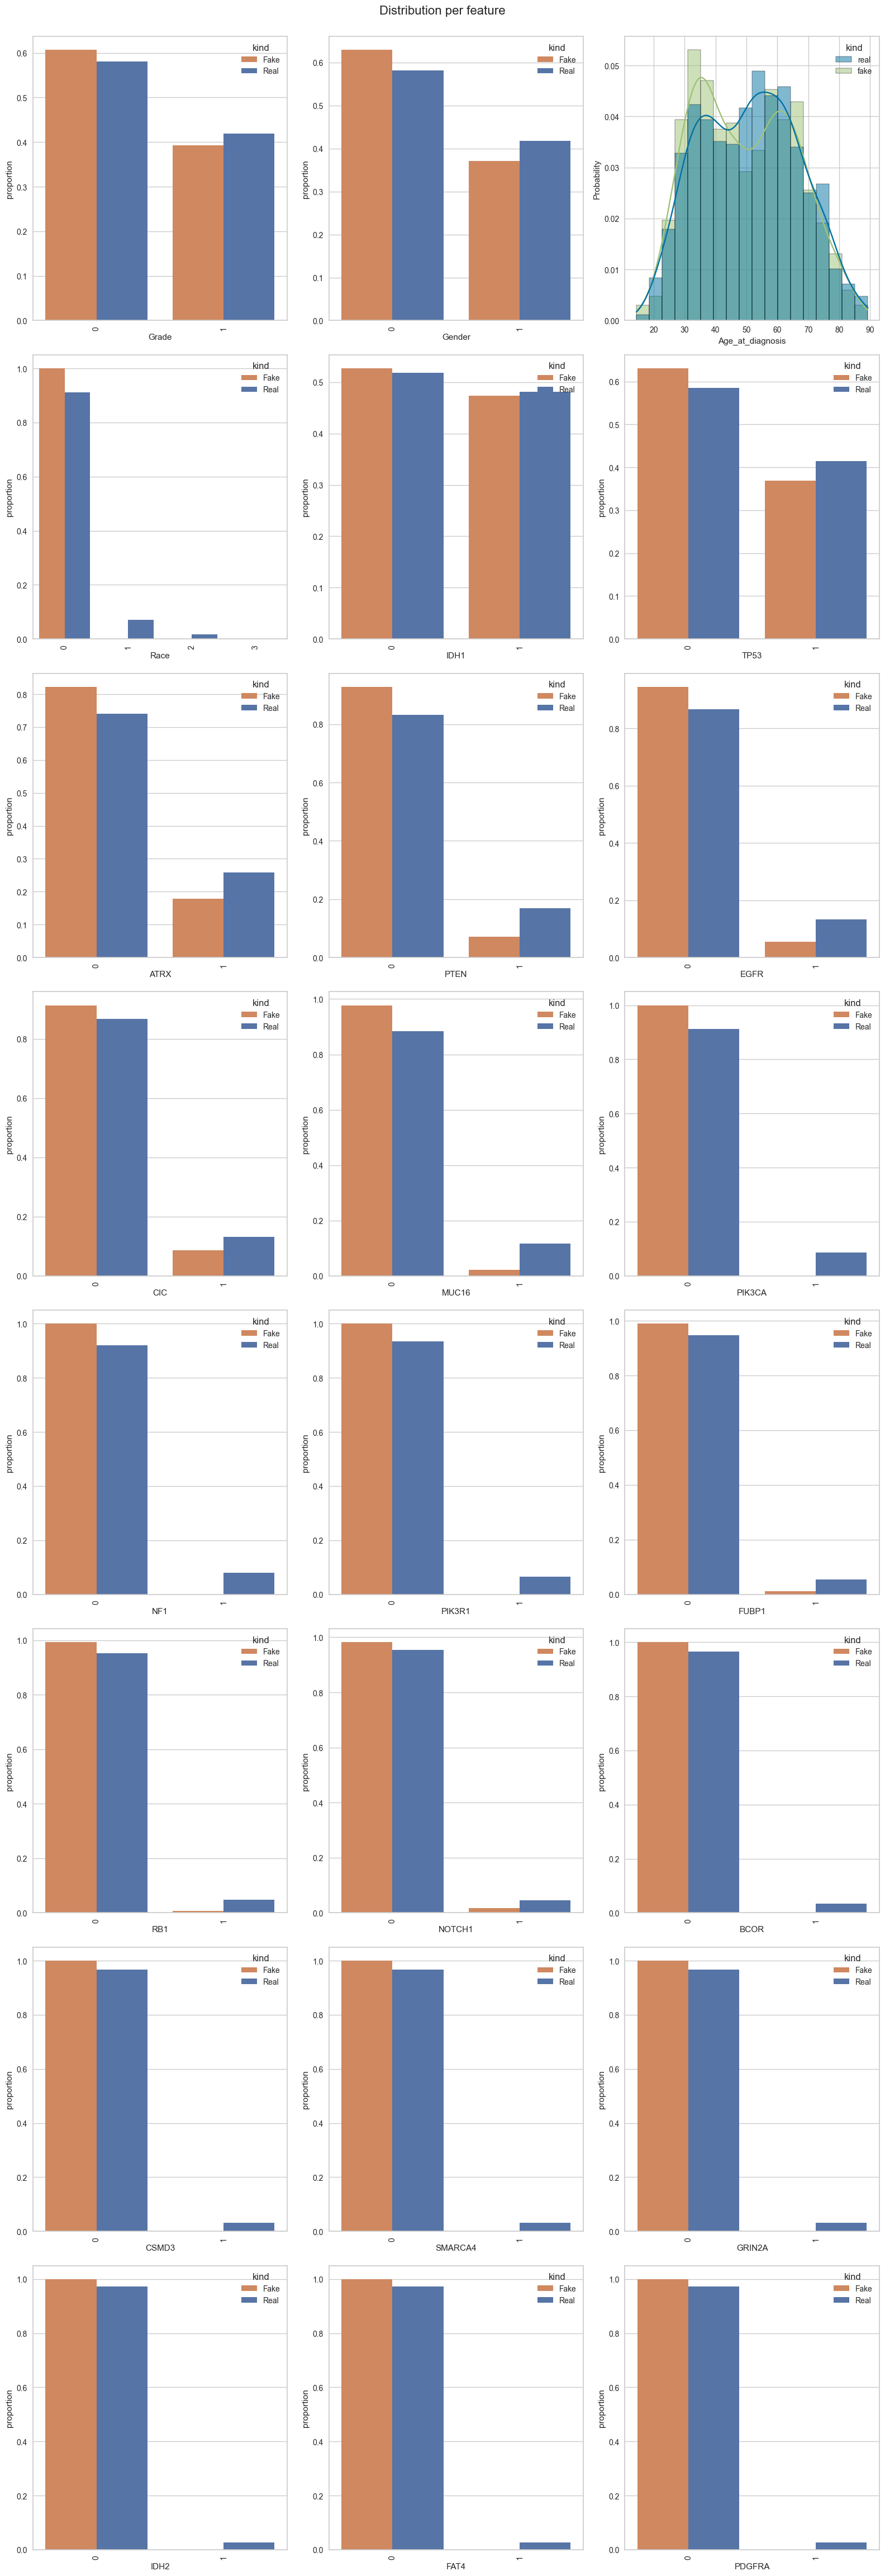

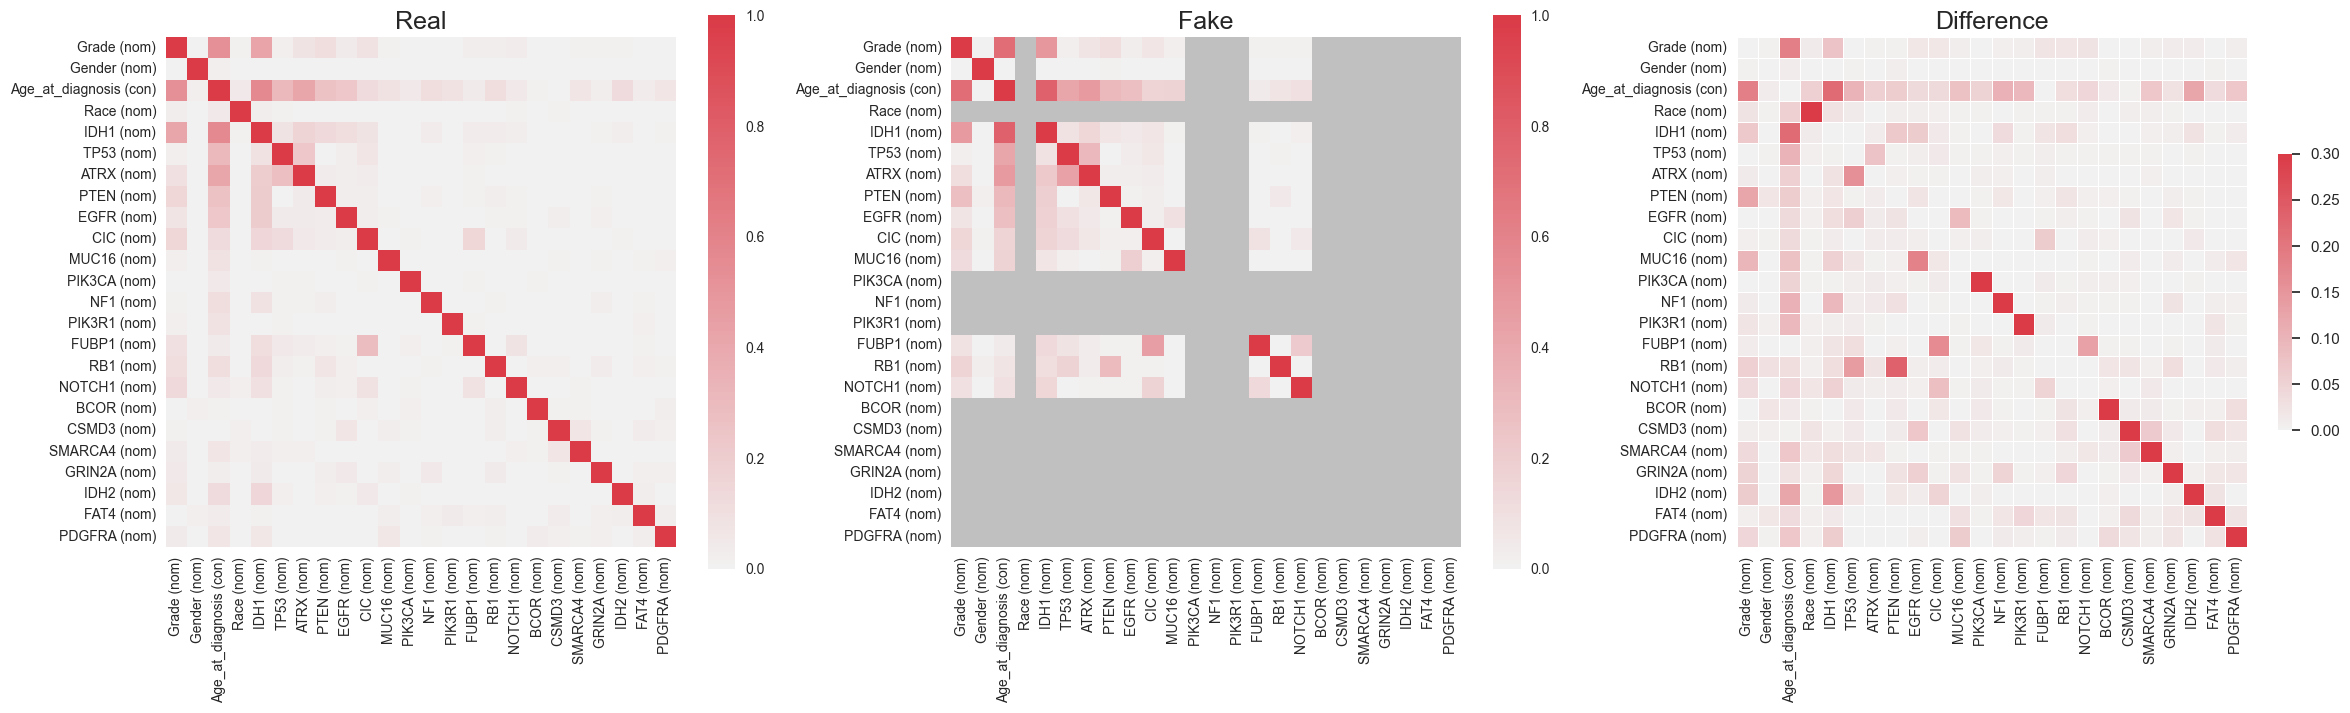

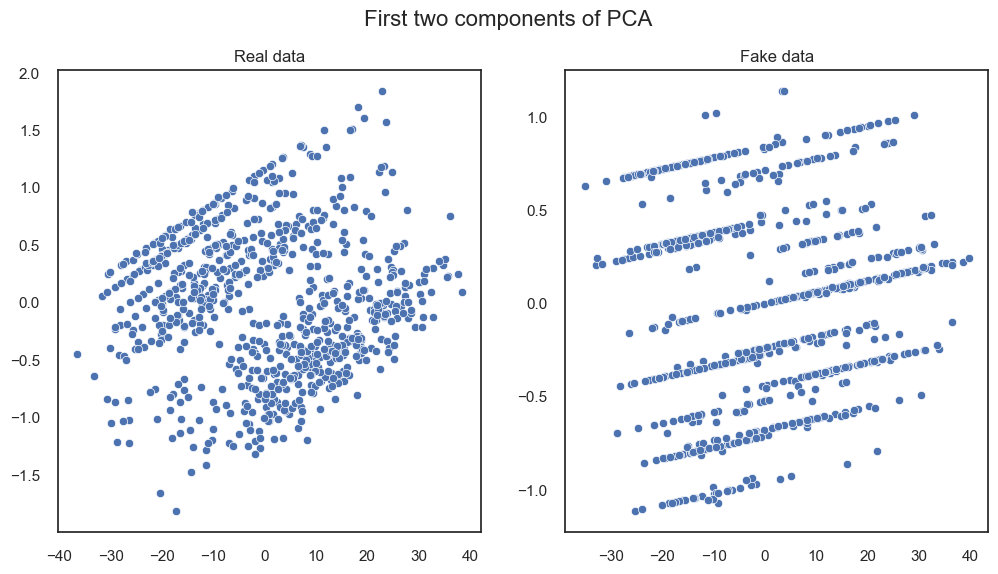

In [7]:
table_evaluator = TableEvaluator(
    real_data, synthetic_data, cat_cols=DISCRETE_COLUMNS
)
table_evaluator.visual_evaluation()

## 6. Compare Classification on Synthetic vs. Real


,Description,Value
0,Session id,123
1,Target,Grade
2,Target type,Binary
3,Original data shape,"(1678, 24)"
4,Transformed data shape,"(1678, 24)"
5,Transformed train set shape,"(839, 24)"
6,Transformed test set shape,"(839, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8880,0.9553,0.9061,0.8307,0.8654,0.7702,0.7739,0.0390
ridge,Ridge Classifier,0.8725,0.9537,0.9636,0.7785,0.8588,0.7462,0.7634,0.0070
lda,Linear Discriminant Analysis,0.8725,0.9540,0.9636,0.7785,0.8588,0.7462,0.7634,0.0720
ada,Ada Boost Classifier,0.8713,0.9493,0.8606,0.8305,0.8423,0.7341,0.7382,0.0370
gbc,Gradient Boosting Classifier,0.8701,0.9517,0.8727,0.8186,0.8416,0.7322,0.7376,0.0480
rf,Random Forest Classifier,0.8617,0.9310,0.8242,0.8274,0.8234,0.7100,0.7130,0.0580
et,Extra Trees Classifier,0.8558,0.9155,0.8152,0.8218,0.8155,0.6974,0.7010,0.0630
lightgbm,Light Gradient Boosting Machine,0.8534,0.9369,0.8333,0.8068,0.8176,0.6954,0.6986,0.5590
knn,K Neighbors Classifier,0.8510,0.9128,0.8273,0.8062,0.8146,0.6904,0.6930,0.0210
nb,Naive Bayes,0.8487,0.9337,0.9576,0.7418,0.8342,0.7000,0.7219,0.0080


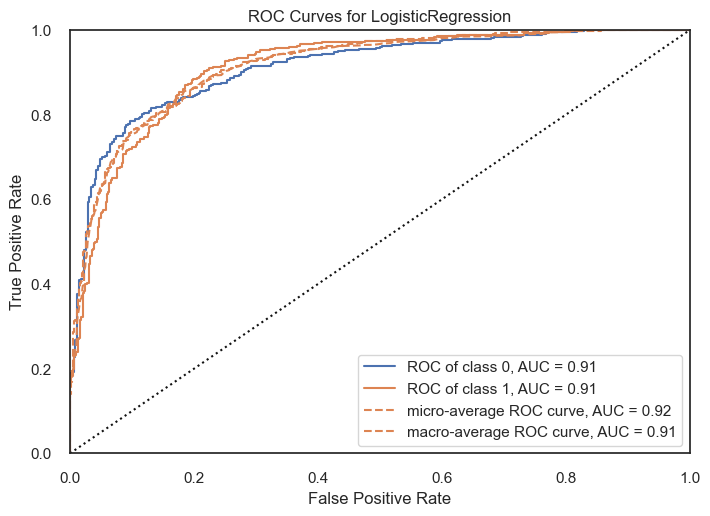

In [8]:
# 6.1 Synthetic → Real
synth_setup = setup(
    data=synthetic_data,
    target='Grade',
    test_data=real_data,
    session_id=SEED,
    n_jobs = None,
    index=False
)
best_synth = compare_models()
plot_model(best_synth, plot='auc')

,Description,Value
0,Session id,123
1,Target,Grade
2,Target type,Binary
3,Original data shape,"(839, 24)"
4,Transformed data shape,"(839, 24)"
5,Transformed train set shape,"(587, 24)"
6,Transformed test set shape,"(252, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8705,0.9187,0.9020,0.8168,0.8540,0.7385,0.7463,0.2200
ridge,Ridge Classifier,0.8705,0.9195,0.9183,0.8077,0.8570,0.7401,0.7490,0.0080
lda,Linear Discriminant Analysis,0.8705,0.9204,0.9183,0.8077,0.8570,0.7401,0.7490,0.0200
gbc,Gradient Boosting Classifier,0.8534,0.9174,0.8853,0.7958,0.8356,0.7044,0.7115,0.0440
ada,Ada Boost Classifier,0.8483,0.9080,0.8568,0.8048,0.8257,0.6921,0.6989,0.0320
rf,Random Forest Classifier,0.8331,0.8925,0.8333,0.7905,0.8066,0.6605,0.6676,0.0530
lightgbm,Light Gradient Boosting Machine,0.8177,0.8871,0.8048,0.7809,0.7879,0.6289,0.6351,0.4520
et,Extra Trees Classifier,0.8092,0.8719,0.7928,0.7704,0.7751,0.6103,0.6184,0.0470
nb,Naive Bayes,0.7908,0.8798,0.9350,0.7038,0.7969,0.5980,0.6288,0.0070
knn,K Neighbors Classifier,0.7906,0.8399,0.7557,0.7524,0.7511,0.5706,0.5741,0.0210


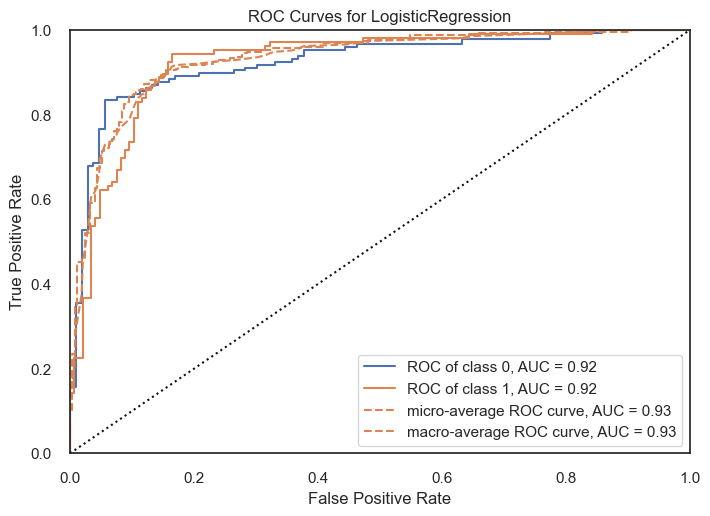

In [9]:
# 6.2 Real only
real_setup = setup(
    data=real_data,
    target='Grade',
    session_id=SEED,
    n_jobs = None,
    index=False
)
best_real = compare_models()
plot_model(best_real, plot='auc')

## 7. Fairness Analysis on Synthetic Data


In [10]:
# --- Prepare synthetic-data features & protected attributes ---
y_syn        = synthetic_data['Grade']
A_gen_syn    = synthetic_data['Gender']
median_age_syn = synthetic_data['Age_at_diagnosis'].median()
A_age_syn    = (synthetic_data['Age_at_diagnosis'] < median_age_syn).astype(int)
X_syn        = synthetic_data.drop(columns=['Grade'])

# --- Split into train/test ---
Xstr_tr, Xstr_te, ystr_tr, ystr_te, gen_tr, gen_te, age_tr, age_te = train_test_split(
    X_syn, y_syn, A_gen_syn, A_age_syn,
    stratify=y_syn,
    test_size=0.3,
    random_state=SEED
)

# --- Train a baseline classifier ---
clf_syn = LogisticRegression(max_iter=1000)
clf_syn.fit(Xstr_tr, ystr_tr)
ystr_pred = clf_syn.predict(Xstr_te)

# --- Group metrics by Gender ---
mf_gen = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=ystr_te,
    y_pred=ystr_pred,
    sensitive_features=gen_te
)
print("=== Synthetic: Group metrics by Gender ===")
print(mf_gen.by_group)

spd_gen = demographic_parity_difference(ystr_te, ystr_pred, sensitive_features=gen_te)
eod_gen = equalized_odds_difference(ystr_te, ystr_pred, sensitive_features=gen_te)
print(f"\nSPD (Gender): {spd_gen:.3f} | EOD (Gender): {eod_gen:.3f}")

# --- Group metrics by Age ---
mf_age = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=ystr_te,
    y_pred=ystr_pred,
    sensitive_features=age_te
)
print("\n=== Synthetic: Group metrics by Age (young=1 / old=0) ===")
print(mf_age.by_group)

spd_age = demographic_parity_difference(ystr_te, ystr_pred, sensitive_features=age_te)
eod_age = equalized_odds_difference(ystr_te, ystr_pred, sensitive_features=age_te)
print(f"\nSPD (Age): {spd_age:.3f} | EOD (Age): {eod_age:.3f}")

=== Synthetic: Group metrics by Gender ===
        accuracy       fpr       fnr
Gender                              
0       0.867925  0.175258  0.064516
1       0.860215  0.178571  0.081081

SPD (Gender): 0.001 | EOD (Gender): 0.017

=== Synthetic: Group metrics by Age (young=1 / old=0) ===
                  accuracy    fpr       fnr
Age_at_diagnosis                           
0                 0.778626  0.675  0.021978
1                 0.958678  0.000  0.625000

SPD (Age): 0.861 | EOD (Age): 0.675


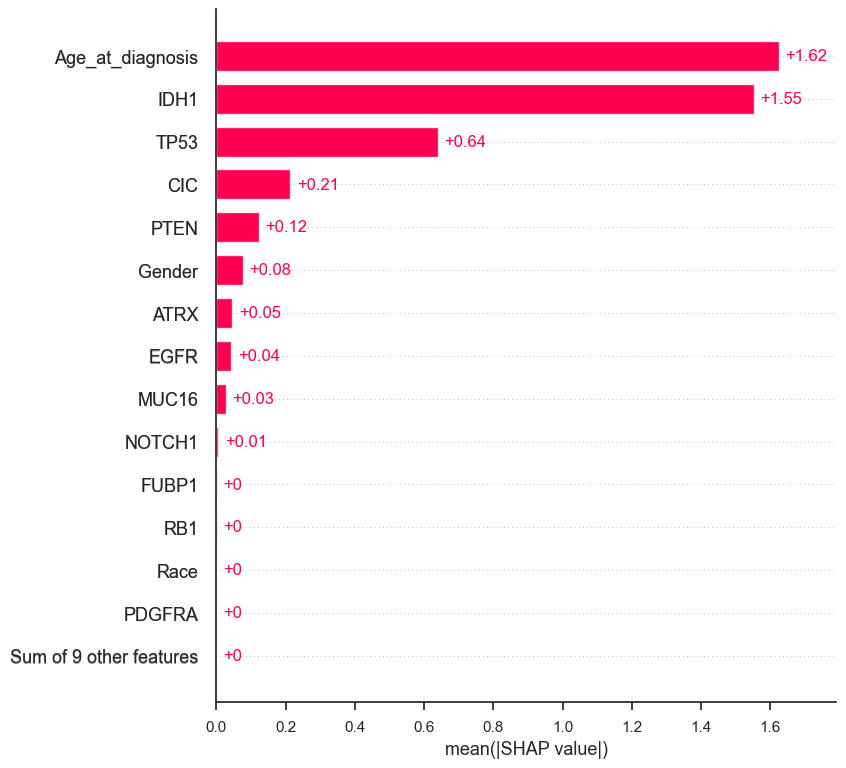

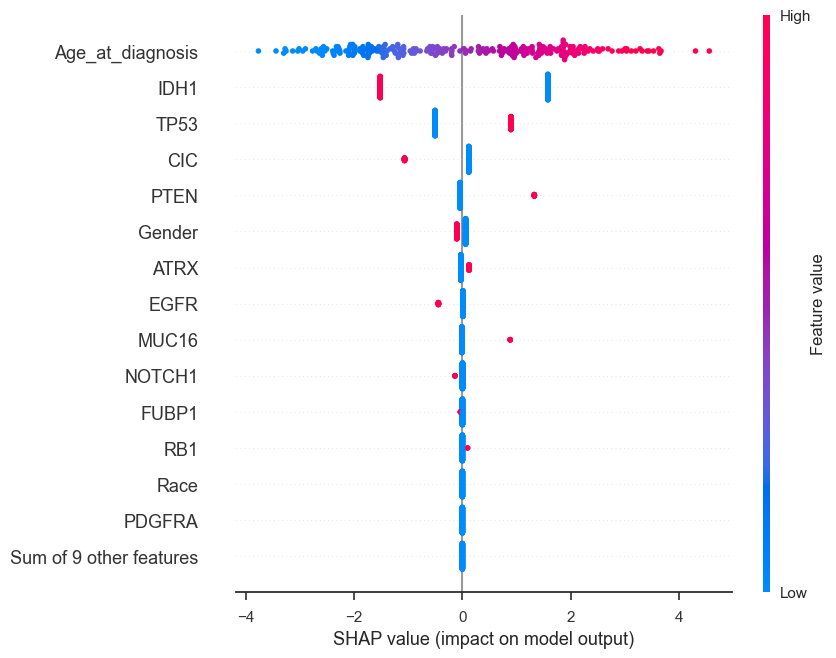

In [11]:
# ---------------------------------------------------------
# ❶  SHAP ANALYSIS – Synthetic-data model
# ---------------------------------------------------------
import shap
from pathlib import Path

# (a) Build an explainer  – exact for linear models
expl_syn = shap.Explainer(clf_syn, Xstr_tr, feature_names=Xstr_tr.columns)

# (b) Compute Shapley values for the *test* split
shap_vals_syn = expl_syn(Xstr_te)

# (c) Global importance – bar plot
shap.plots.bar(shap_vals_syn, max_display=15, show=True)

# (d) Summary dot-plot (beeswarm)
shap.plots.beeswarm(shap_vals_syn, max_display=15, show=True)

# (e) Store results so they survive the notebook kernel
Path("outputs").mkdir(exist_ok=True)

## 8. Fairness Analysis on Real Data


In [12]:
# --- Prepare real-data features & protected attributes ---
y_real        = real_data['Grade']
A_gen_real    = real_data['Gender']
median_age_real = real_data['Age_at_diagnosis'].median()
A_age_real    = (real_data['Age_at_diagnosis'] < median_age_real).astype(int)
X_real        = real_data.drop(columns=['Grade'])

# --- Split into train/test ---
Xr_tr, Xr_te, yr_tr, yr_te, genr_tr, genr_te, ager_tr, ager_te = train_test_split(
    X_real, y_real, A_gen_real, A_age_real,
    stratify=y_real,
    test_size=0.3,
    random_state=SEED
)

# --- Train a baseline classifier ---
clf_real = LogisticRegression(max_iter=1000)
clf_real.fit(Xr_tr, yr_tr)
yr_pred = clf_real.predict(Xr_te)

# --- Group metrics by Gender ---
mf_real_gen = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=yr_te,
    y_pred=yr_pred,
    sensitive_features=genr_te
)
print("=== Real: Group metrics by Gender ===")
print(mf_real_gen.by_group)

spd_real_gen = demographic_parity_difference(yr_te, yr_pred, sensitive_features=genr_te)
eod_real_gen = equalized_odds_difference(yr_te, yr_pred, sensitive_features=genr_te)
print(f"\nSPD (Gender, real): {spd_real_gen:.3f} | EOD (Gender, real): {eod_real_gen:.3f}")

# --- Group metrics by Age ---
mf_real_age = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "fpr": false_positive_rate,
        "fnr": false_negative_rate
    },
    y_true=yr_te,
    y_pred=yr_pred,
    sensitive_features=ager_te
)
print("\n=== Real: Group metrics by Age (young=1 / old=0) ===")
print(mf_real_age.by_group)

spd_real_age = demographic_parity_difference(yr_te, yr_pred, sensitive_features=ager_te)
eod_real_age = equalized_odds_difference(yr_te, yr_pred, sensitive_features=ager_te)
print(f"\nSPD (Age, real): {spd_real_age:.3f} | EOD (Age, real): {eod_real_age:.3f}")

=== Real: Group metrics by Gender ===
        accuracy       fpr       fnr
Gender                              
0       0.897810  0.112676  0.090909
1       0.843478  0.213333  0.050000

SPD (Gender, real): 0.027 | EOD (Gender, real): 0.101

=== Real: Group metrics by Age (young=1 / old=0) ===
                  accuracy       fpr       fnr
Age_at_diagnosis                              
0                 0.843750  0.395349  0.035294
1                 0.903226  0.067961  0.238095

SPD (Age, real): 0.588 | EOD (Age, real): 0.327


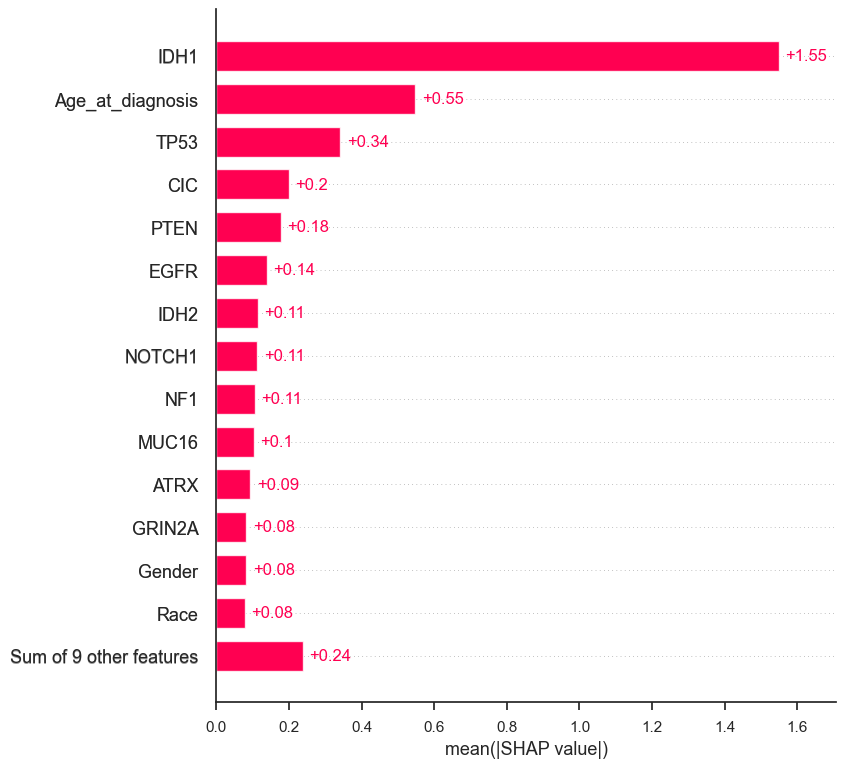

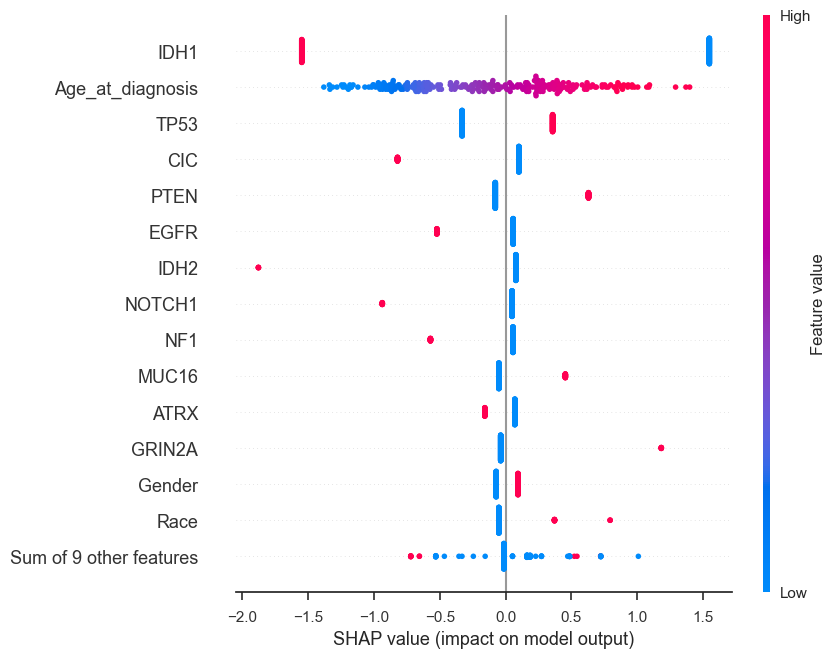

In [13]:
# ---------------------------------------------------------
# ❷  SHAP ANALYSIS – Real-data model
# ---------------------------------------------------------
expl_real = shap.Explainer(clf_real, Xr_tr, feature_names=Xr_tr.columns)
shap_vals_real = expl_real(Xr_te)

shap.plots.bar(shap_vals_real, max_display=15, show=True)
shap.plots.beeswarm(shap_vals_real, max_display=15, show=True)
